In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import spacy

RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
RANDON_STATE = 42

In [2]:
df_cleaned = pd.read_parquet(INTERIM_FOLDER + "df_cleaned.pqt")

df_cleaned.head()

,Date received,Consumer complaint narrative,Company,Issue,Product,Product_revised
1798352,2015-09-21,Opened a credit card account in XX/XX/XXXX. In...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card,Credit card
1947691,2016-08-02,I have a credit card for our business with 5/3...,FIFTH THIRD FINANCIAL CORPORATION,APR or interest rate,Credit card,Credit card
1850494,2015-11-04,I have been a Discover credit card member sinc...,DISCOVER BANK,APR or interest rate,Credit card,Credit card
1872829,2016-05-20,XXXX/XXXX/XXXX made a purchase for {$2500.00} ...,"CITIBANK, N.A.",APR or interest rate,Credit card,Credit card
1851488,2015-12-17,I have been making automated payments for seve...,"CITIBANK, N.A.",APR or interest rate,Credit card,Credit card


In [3]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

X = df_cleaned["Consumer complaint narrative"]
y = df_cleaned["Product_revised"]

X_tfidf = tfidf.fit_transform(X)
print(f"""X: {X.shape}
y: {y.shape}""")

X: (795448,)
y: (795448,)


In [4]:
y.unique().tolist()

['Credit card',
 'Bank account or service',
 'Payday loan, title loan, or personal loan',
 'Other financial service',
 'Mortgage',
 'Debt collection',
 'Checking or savings account',
 'Credit reporting',
 'Money transfer, virtual currency, or money service']

In [5]:
N = 2
for Product in sorted(y.unique().tolist()):
    features_chi2 = chi2(X_tfidf, y == Product)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("-"*60, "\n")

# 'Bank account or service':
  . Most correlated unigrams:
. citigold
. overdraft
  . Most correlated bigrams:
. citigold checking
. overdraft fees
------------------------------------------------------------ 

# 'Checking or savings account':
  . Most correlated unigrams:
. checking
. deposit
  . Most correlated bigrams:
. savings account
. checking account
------------------------------------------------------------ 

# 'Credit card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. american express
. credit card
------------------------------------------------------------ 

# 'Credit reporting':
  . Most correlated unigrams:
. equifax
. report
  . Most correlated bigrams:
. identity theft
. credit report
------------------------------------------------------------ 

# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collection agency
. collect debt
-----------------------------------------------------------

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDON_STATE)

pipe = Pipeline([
    ('tfidf_vec', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
    ('log_reg', LogisticRegression(penalty="l2", max_iter=100, tol=0.001, random_state=RANDON_STATE, n_jobs=-1))
])

pipe.fit(X_train, y_train)

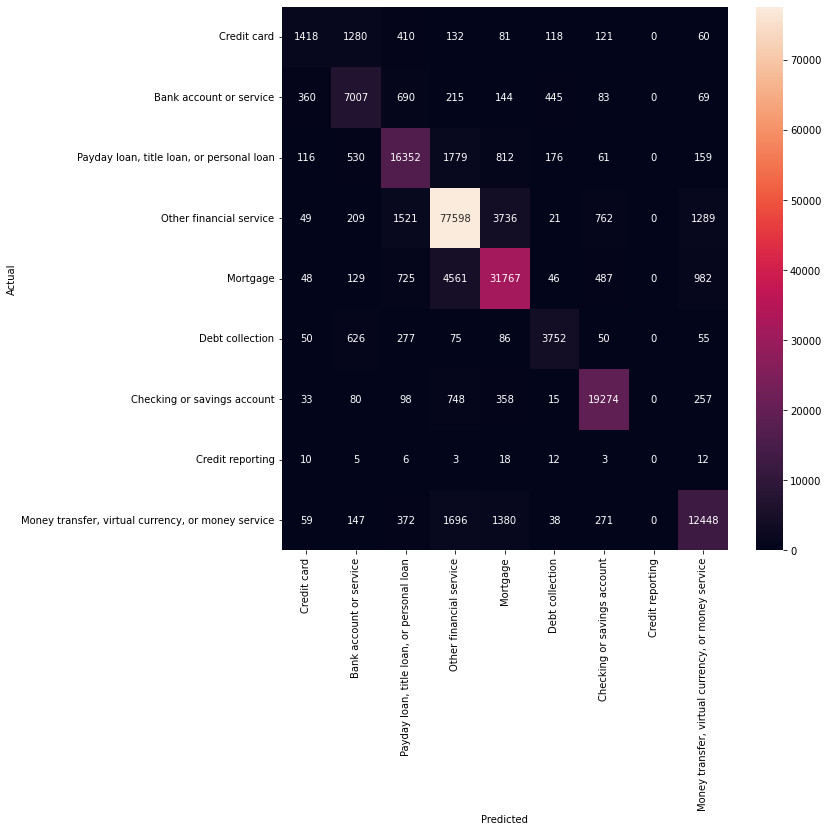

In [ ]:
y_pred = pipe.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=y.unique().tolist(), yticklabels=y.unique().tolist()
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=df_cleaned['Product_revised'].unique(), zero_division=0))

                                                    precision    recall  f1-score   support

                                       Credit card       0.66      0.39      0.49      3620
                           Bank account or service       0.70      0.78      0.74      9013
         Payday loan, title loan, or personal loan       0.80      0.82      0.81     19985
                           Other financial service       0.89      0.91      0.90     85185
                                          Mortgage       0.83      0.82      0.82     38745
                                   Debt collection       0.81      0.75      0.78      4971
                       Checking or savings account       0.91      0.92      0.92     20863
                                  Credit reporting       0.00      0.00      0.00        69
Money transfer, virtual currency, or money service       0.81      0.76      0.78     16411

                                          accuracy                           0